# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [49]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [97]:
qubit = 0
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

x_amp = 0.10218341976411754
drive_betas = np.linspace(-20, 20, 51)

drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(drive_freq, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

In [125]:
# n = 1

for k in range(1):
    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    n = 2*k + 1
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    exp_DRAG_circuits_n1 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [127]:
# n = 3

for k in range(2):
    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    n = 2*k + 1
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    exp_DRAG_circuits_n3 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [128]:
# n = 5

for k in range(3):
    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    n = 2*k + 1
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    exp_DRAG_circuits_n5 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

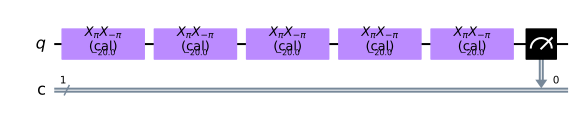

In [129]:
exp_DRAG_circuits_n5[0].draw()

In [130]:
# n = 7

for k in range(4):
    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    n = 2*k + 1
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    exp_DRAG_circuits_n7 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

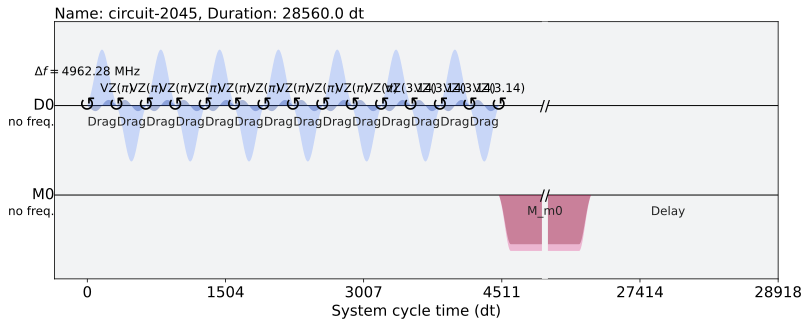

In [131]:
schedule(exp_DRAG_circuits_n7[7], backend).draw()

In [198]:
dragJob_n1 = backend.run(exp_DRAG_circuits_n1, 
                  meas_level=MeasLevel.KERNELED, 
                  meas_return=MeasReturnType.SINGLE,  # CHANGE TO MeasReturnType.AVERAGE for average measurement level 1
                  shots=2**14)
print(dragJob_n1.job_id())

633d37471b246c454c72d197


In [199]:
dragJob_n3 = backend.run(exp_DRAG_circuits_n3, 
                  meas_level=MeasLevel.KERNELED, 
                  meas_return=MeasReturnType.SINGLE, 
                  shots=2**14)
print(dragJob_n3.job_id())

633d37ffd808539c416a4c68


In [200]:
dragJob_n5 = backend.run(exp_DRAG_circuits_n5, 
                  meas_level=MeasLevel.KERNELED, 
                  meas_return=MeasReturnType.SINGLE, 
                  shots=2**14)
print(dragJob_n5.job_id())

633d38017f697ba28f64889e


In [201]:
dragJob_n7 = backend.run(exp_DRAG_circuits_n7, 
                  meas_level=MeasLevel.KERNELED, 
                  meas_return=MeasReturnType.SINGLE, 
                  shots=2**14)
print(dragJob_n7.job_id())

633d3803d8085381f26a4c69


In [202]:
job_monitor(dragJob_n1)
job_monitor(dragJob_n3)
job_monitor(dragJob_n5)
job_monitor(dragJob_n7)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [205]:
dragJob_n1 = backend.retrieve_job('633d37471b246c454c72d197')
dragJob_n3 = backend.retrieve_job('633d37ffd808539c416a4c68')
dragJob_n5 = backend.retrieve_job('633d38017f697ba28f64889e')
dragJob_n7 = backend.retrieve_job('633d3803d8085381f26a4c69')

In [162]:
drag_results_n1 = dragJob_n1.result(timeout=120)
drag_values_n1 = []
for i in range(num_beta_points):
    drag_values_n1.append(drag_results_n1.get_memory(i)[qubit] * 1e-7)

In [163]:
drag_results_n3 = dragJob_n3.result(timeout=120)
drag_values_n3 = []
for i in range(num_beta_points):
    drag_values_n3.append(drag_results_n3.get_memory(i)[qubit] * 1e-7)

In [164]:
drag_results_n5 = dragJob_n5.result(timeout=120)
drag_values_n5 = []
for i in range(num_beta_points):
    drag_values_n5.append(drag_results_n5.get_memory(i)[qubit] * 1e-7)

In [165]:
drag_results_n7 = dragJob_n7.result(timeout=120)
drag_values_n7 = []
for i in range(num_beta_points):
    drag_values_n7.append(drag_results_n7.get_memory(i)[qubit] * 1e-7)

<function matplotlib.pyplot.show(close=None, block=None)>

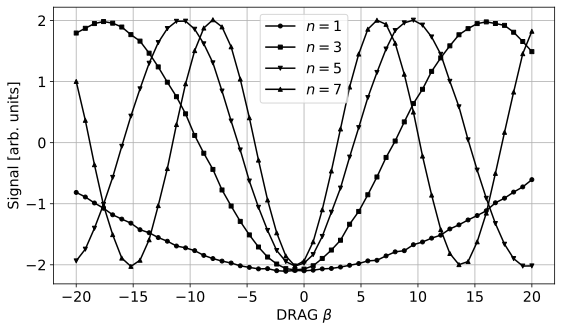

In [195]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)    

plt.plot(drive_betas, drag_values_n1, marker='o', markersize=4, linestyle='-', color='black', label='$n=1$')
plt.plot(drive_betas, drag_values_n3, marker='s', markersize=4, linestyle='-', color='black', label='$n=3$')
plt.plot(drive_betas, drag_values_n5, marker='v', markersize=4, linestyle='-', color='black', label='$n=5$')
plt.plot(drive_betas, drag_values_n7, marker='^', markersize=4, linestyle='-', color='black', label='$n=7$')
plt.xlabel(r'DRAG $\beta$')
plt.ylabel('Signal [arb. units]')
plt.grid()
plt.legend()
plt.show

In [186]:
beta_cal = drive_betas[np.argmax(drag_values_n1[:,0])]

TypeError: list indices must be integers or slices, not tuple

In [206]:
drag_results_n3 = dragJob_n3.result(timeout=120)
drag_values_n3_A = []
for i in range(len(drive_betas)):
    drag_values_n3_A.append([drag_results_n3.get_memory(i).real[:,0], drag_results_n3.get_memory(i)[:,0].imag])
drag_values_n3_A = np.squeeze(np.array(drag_values_n3_A)).T

In [209]:
len(drag_values_n3_A)/2**14

1.0

In [210]:
drag_values_n3_A

array([[[  1250986.,  18803736.,  16648801., ...,  29562896.,
         -34976640.,  23312802.],
        [ -8888558., -17360100., -36070712., ..., -22486284.,
         -43695672., -30984744.]],

       [[ 19013608.,   3158515.,  32285028., ...,  22402012.,
         -27907220.,  -9042295.],
        [-22520398., -35157456., -24922500., ..., -17506176.,
         -25739202., -29427000.]],

       [[  5720814.,  13677466.,   1067092., ...,  18645600.,
         -20945308.,  12061408.],
        [-44386152., -16953070., -24837640., ..., -16761689.,
         -19388198., -19298972.]],

       ...,

       [[ 16939928.,  23664424.,   7046832., ..., -14127599.,
          14193874.,  23940144.],
        [-30154440., -30968274., -31431022., ..., -27277932.,
         -15200537., -36559164.]],

       [[ 14821524.,  13571206.,  11678489., ...,  30602054.,
            124931.,  25517156.],
        [-40317612., -17674784., -36331256., ..., -42177416.,
         -39907320., -25526640.]],

       [[  -31466